<a href="https://colab.research.google.com/github/AlenaPotato/university_projects/blob/main/%D0%A3%D0%BF%D1%80%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%20%D0%B1%D0%B0%D0%BD%D0%BA%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%BC%D0%B8%20%D1%80%D0%B8%D1%81%D0%BA%D0%B0%D0%BC%D0%B8/%D0%9B%D0%B8%D0%BC%D0%B8%D1%82%D1%8B_%D0%BD%D0%B0_%D1%80%D1%8B%D0%BD%D0%BE%D1%87%D0%BD%D1%8B%D0%B9_%D1%80%D0%B8%D1%81%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подводка для модели


Задача данной работы - построить рейтинговую модель, прогнозирующую дефолт компании.

Для оценки модели будут использоваться несколько характеристик: показатели финансовой устойчивости, ликвидности и деловой активности. На основе рассчитанных показателей будет построена логит модель.

---
Поскольку в РФ проблема с фиксацией дефолтов, то мы примем за событие дефолта отрицательное сальдо денежных потоков за отчетный период - это переменная "cf".Объясняющими переменными будут показатели за предыдущие годы. База упрощенная, поэтому показатели только за 2017 год - это переменные с названием "_lag" на конце.


Вероятность дефолта контрагента может быть оценена на основе публикуемых кредитных рейтингов, которые, в свою очередь, присваиваются агентствами по результатам анализа финансовой отчетности предприятий.

# Подготовка данных

## Расшифровка параметров

In [ ]:
#                   имя столбца                 расшифровка                                               строка баланса
dict_description = {'title':                    'Короткое название организации',
                    'org':                      'Тип юридического лица (часть наименования организации)',
                    'ok1':                      'Код ОКВЭД первого уровня',
                    'ok2':                      'Код ОКВЭД второго уровня',
                    'ok3':                      'Код ОКВЭД третьего уровня',
                    'region':                   'Код региона по ИНН',

                    # Бухгалтерский баланс
                    'of':                       'Основные средства',                                      # 1130
                    'ta_nonfix_fin':	          'Фин. вложения',                                          # 1170
                    'ta_fix':                   'Итого внеоборотных активов',                             # 1100

                    'inventory':	              'Запасы',                                                 # 1210
                    'receivables':	            'Дебиторская задолженность',                              # 1230
                    'cash':                     'Денежные средства и денежные эквиваленты',               # 1250
                    'ta_nonfix':                'Итого оборотных активов',                                # 1200

                    'ta':                       'БАЛАНС (актив)',                                         # 1600

                    'tp_capital':               'Собственный капитал',                                    # 1300

                    'debt_long':                'Долгосрочные заемные средства',                          # 1410
                    'tp_long':                  'Итого долгосрочных обязательств',                        # 1400

                    'debt_short':               'Краткосрочные заемные обязательства',                    # 1510
                    'payables':	                'Кредиторская задолженность',                             # 1520
                    'tp_short_future_income':	  'Доходы будущих периодов',                                # 1530
                    'tp_short_estimated':	      'Оценочные обязательства',                                # 1540
                    'tp_short_other':         	'Прочие обязательства',                                   # 1550
                    'tp_short':                 'Итого краткосрочных обязательств',                       # 1500

                    'tp':                       'БАЛАНС (пассив)',                                        # 1600

                    # Отчёт о финансовых результатах
                    'sales':                    'Выручка',                                                # 2110
                    'profit_oper':              'Прибыль (убыток) от продаж',                             # 2200
                    'exp_interest':             'Проценты к уплате',                                      # 2330
                    'profit_before_tax':        'Прибыль (убыток) до налогообложения',                    # 2300
                    'profit_after_tax':         'Чистая прибыль (убыток)',                                # 2400

                    # Отчёт о движении денежных средств
                    'cf_oper_in':               'Поступления - всего',                                    # 4110
                    'cf_oper_in_sales':         'От продажи продукции, товаров, работ и услуг',           # 4111
                    'cf_oper_out':              'Платежи - всего',                                        # 4120
                    'paid_to_supplier':         'Поставщикам (подрядчикам) за сырье, материалы, работы, услуги', # 4121
                    'paid_to_worker':           'В связи с оплатой труда работников',                     # 4122
                    'paid_interest':            'Проценты по долговым обязательствам',                    # 4123
                    'paid_profit_tax':          'Налог на прибыль организаций',                           # 4124
                    'paid_other_costs':         'Прочие платежи',                                         # 4129
                    'cf_oper':                  'Сальдо денежных потоков от текущих операций',            # 4100
                    'cf_inv_in':                'Поступления - всего',                                    # 4210
                    'cf_inv_out':               'Платежи - всего',                                        # 4220
                    'paid_fa_investment':       'В связи с приобретением, созданием, модернизацией, реконструкцией и подготовкой к использованию внеоборотны активов', # 4221
                    'cf_inv':                   'Сальдо денежных потоков от инвестиционных операций',     # 4200
                    'cf_fin_in':                'Поступления - всего',                                    # 4310
                    'cf_fin_out':               'Платежи - всего',                                        # 4320
                    'cf_fin':                   'Сальдо денежных потоков от финансовых операций',         # 4300
                    'cf':                       'Сальдо денежных потоков за отчетный период'              # 4400
}

## Подгрузка и обработка данных

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

import scipy

In [ ]:
data = pd.read_excel('/content/корпоративная_база_данных_2018.xlsx', sheet_name='Sheet1')
print(f'Размерность данных: {data.shape}')

Размерность данных: (20598, 75)


In [ ]:
general = ['inn', 'ok1',	'ok2',	'ok3',	'region']
to_drop = ['title', 'org', 'okpo', 'okopf', 'okfs', 'okved', 'unit']
for_coef_eval = ['tp_capital', 'tp_long', 'debt_long', 'debt_short', 'ta', 'cash', 'tp_short', 'tp_short_future_income', 'tp_short_estimated',
                 'profit_after_tax', 'of', 'ta_fix', 'sales', 'inventory', 'profit_before_tax', 'exp_interest', 'ta_nonfix']

In [ ]:
# Выделение данных за 2017й год
columns_2017 = [col for col in data.columns if 'lag' in col]
data_2017 = data[columns_2017]

new_2017_columns = [i.replace('_lag', "") for i in data_2017.columns]
data_2017.columns = new_2017_columns


In [ ]:
# Выделение данных за 2018й год
columns_2018 = data.columns[~data.columns.isin(columns_2017+to_drop+general)]
data_2018 = data[columns_2018]

In [ ]:
# np.round(data_2018[for_coef_eval].iloc[:,8:17].rename(columns=dict_description).describe(),2)

In [ ]:
print(f'Данные за 2018й год содержат {data_2018.shape[0]} строк и {data_2018.shape[1]} столбцов.')
print(f'Данные за 2017й год содержат {data_2017.shape[0]} строк и {data_2017.shape[1]} столбцов.')

Данные за 2018й год содержат 20598 строк и 40 столбцов.
Данные за 2017й год содержат 20598 строк и 23 столбцов.


Данные за 2017 и 2018 года содержат разное количество переменных (столбцов). Это связано с тем, что за 2018 есть данные отчёта о "Денежных потоках от финансовых операций", а за 2017 - нет.

Поскольку для расчёта коэффициентов этот отчёт необходим, то для определения зависимой переменной (дефолт) я буду использовать данные только за 2018й год.


## Определение зависимой переменной

Организации присваивается 1 – дефолт, если у компании не было движения денежных средств.

In [ ]:
# Переменные, которые помогут определить признак дефолта
default = ['cf_oper_in', 'cf_oper_in_sales', 'cf_oper_out', 'paid_to_supplier', 'paid_interest', 'paid_profit_tax', 'paid_other_costs',
           'cf_oper', 'cf_inv_in', 'cf_inv_out', 'paid_fa_investment', 'cf_inv', 'cf_fin_in', 'cf_fin_out', 'cf_fin', 'cf', 'sales']

In [ ]:
# Собираю индексы, где произошёл дефолт
list_of_indexes = [data_2018[data_2018[col] == 0].index.values for col in default]

from itertools import chain
new_list_of_indexes = list(set(list(chain.from_iterable([i.tolist() for i in list_of_indexes]))))

In [ ]:
# Создаю зависимую переменную
data_2018['y'] = 0
data_2018.loc[new_list_of_indexes, 'y'] = 1

<ipython-input-174-9904725e4679>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2018['y'] = 0


## Агрегирование отрасли

Делить организации буду по видам экономической деятельности. Для этого мне понадобятся коды ОКВЭД.

В данных представлено три кода ОКВЭД. Код ОКВЭД третьего уровня - необязательная часть кода, поэтому в определении группы буду ориентироваться на первые два уровня.

In [ ]:
print(f"Коды ОКВЭД первого уровня: {len(data['ok1'].unique())}")
print(f"Коды ОКВЭД второго уровня: {len(data['ok2'].unique())}")

temp = data[['ok1', 'ok2']].astype(str).agg('.'.join, axis=1)
print(f"Коды ОКВЭД при объединении первого и второго уровня: {len(temp.unique())}")

Коды ОКВЭД первого уровня: 83
Коды ОКВЭД второго уровня: 87
Коды ОКВЭД при объединении первого и второго уровня: 630


При комбинировании кодов первого и второго уровней, получается много групп агрегации. Буду агрегировать по первому уровню кодов ОКВЭД.

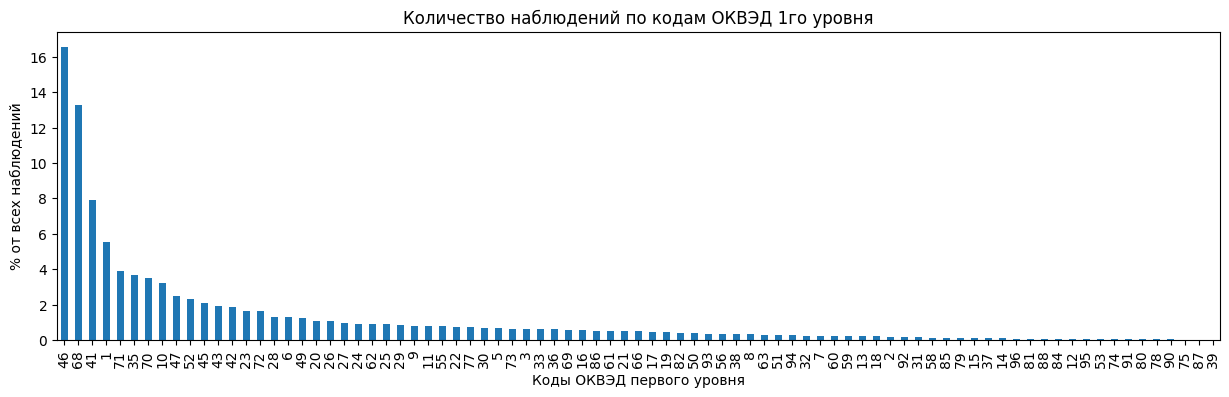

In [ ]:
temp = data['ok1'].value_counts(normalize=True).sort_values(ascending=False)*100

temp.plot(kind='bar', figsize=(15,4))
plt.xlabel('Коды ОКВЭД первого уровня')
plt.ylabel('% от всех наблюдений')
plt.title('Количество наблюдений по кодам ОКВЭД 1го уровня')
plt.show()

Оставлю только те виды деятельности, по которым количество наблюдений в имеющихся данных составляет хотя бы 1%.  

In [ ]:
print(f'В анализ войдёт {len(temp[temp>1])} отраслей.')
print('В модель войдут следующие направления деятельности:')
print(temp.index[:10].values)
print(temp.index[10:20].values)

В анализ войдёт 20 отраслей.
В модель войдут следующие направления деятельности:
[46 68 41  1 71 35 70 10 47 52]
[45 43 42 23 72 28  6 49 20 26]


Изучу, какие отрасли войдут в модель.

In [ ]:
okved = pd.read_html('https://assistentus.ru/okved/?ysclid=ls390oe9ma906486935')[0]

okved.drop(index=[okved[okved['Код раздела/класса']==i].index[0] for i in okved['Код раздела/класса'] if 'Раздел' in i],
           inplace=True)

okved['Код раздела/класса'] = okved['Код раздела/класса'].astype(int)
okved.set_index('Код раздела/класса', inplace=True)

In [ ]:
okved.loc[temp.index[:20].values]

,Наименование раздела/класса
Код раздела/класса,
46,"Торговля оптовая, кроме оптовой торговли автот..."
68,Операции с недвижимым имуществом
41,Строительство зданий
1,"Растениеводство и животноводство, охота и пред..."
71,Деятельность в области архитектуры и инженерно...
35,"Обеспечение электрической энергией, газом и па..."
70,Деятельность головных офисов; консультирование...
10,Производство пищевых продуктов
47,"Торговля розничная, кроме торговли автотранспо..."


Как можно заметить, в модель войдёт достаточно широкий сектор областей экономики.

In [ ]:
# Создам словарь для расшифровки отраслей
okved_dict = {k:v for k, v in zip(['ok1_'+ str(i) for i in okved.index], okved['Наименование раздела/класса'])}

## Рассчёт коэффициентов

Поскольку есть период наблюдения дефолта, и есть период наблюдения факторов, то в качестве объясняющих переменных будут приняты показатели экономической активности за 2018й год.

Финансовая устойчивость характеризует степень зависимости организации от внешних источников финансирования и ее возможность отвечать по своим текущим обязательствам в будущем. Таким образом, показатели устойчивости призваны отражать степень надежности компании в перспективе.

Показатели ликвидности характеризуют платежеспособность компании. При этом рассчитывается только возможность погашать свои краткосрочные обязательства.

Деловая активность гарантирует стабильности финансового положения предприятия на рынке. Деловая активность предприятия в финансовом аспекте проявляется, прежде всего, в скорости оборота его средств.

1. ***Коэффициент устойчивого финансирования*** показывает устойчивость финансового положения организации на рынке. (Собственный капитал + Долгосрочные кредиты и займы) / Валюта баланса

2. ***Коэффициент автономии*** - коэффициент показывает, насколько организация независима от кредиторов. Чем меньше значение коэффициента, тем в большей степени организация зависима от заемных источников финансирование, тем менее устойчивое у нее финансовое положение. Собственный капитал / Активы

3. ***Коэффициент соотношения заемных и собственных средств*** показывает, сколько заемных средств приходится на единицу собственного капитала. (КО + ДО) / СК

4. ***Коэффициент финансовой зависимости*** показывает, какую долю во всей структуре капитала занимают заемные средства. Активы / Собственный капитал

5. ***Коэффициент абсолютной ликвидности*** отражает достаточность наиболее ликвидных активов для быстрого расчета по текущим обязательствам. (Денежные средства + Краткосрочные финансовые вложения) / Текущие обязательства

6. ***Коэффициент рентабельности продаж*** характеризует эффективность ресурсов организации. Чистая прибыль (убыток) / Выручка

7. ***Коэффициент рентабельности основных средств*** показывает эффективность использования основных средств. Чистая прибыль (убыток) / Основные средства

8. ***Коэффициент рентабельности внеоборотных активов*** показывает эффективность использования внеоборотных средств. Чистая прибыль (убыток) / Внеоборотны активы

9. ***Коэффициент оборачиваемости материальных оборотных средств*** характеризует рациональность и интенсивность использования оборотных средств в организации. Выручка от продаж / Запасы


10. ***Коэффициент устойчивости экономического роста*** показывает темп изменения собственного капитала за счет реинвестирования нераспределенной прибыли, то есть за счет финансово-хозяйственной деятельности организации. Будет рассчитываться как чистая прибыль / собственный капитал.

11. ***Коэффициент покрытия процентов*** (interest coverage ratio ICR) характеризует способность организации обслуживать свои долговые обязательства. Коэффициент покрытия процентов = EBIT / Проценты к уплате. Чем выше коэффициент покрытия процентов, тем более устойчивое финансовое положении организации.

12. ***Общий коэффициент покрытия*** показывает способность компании погашать текущие (краткосрочные) обязательства за счёт только оборотных активов. Оборотные активы / Текущие обязательства


In [ ]:
def coefs(df):
  '''Функция рассчитывает необходимые для модели коэффициенты'''

  k1 = (df['tp_capital'] + df['tp_long']) / df['ta']
  k2 = df['tp_capital'] / df['ta']
  k3 = (df['debt_long'] + df['debt_short']) / df['tp_capital']
  k4 = df['ta'] / df['tp_capital']
  k5 = df['cash'] / (df['tp_short'] - df['tp_short_future_income'] - df['tp_short_estimated'])
  k6 = df['profit_after_tax'] / df['sales'] *100
  k7 = df['profit_after_tax'] / df['of']
  k8 = df['profit_after_tax'] / df['ta_fix']
  k9 = df['sales'] / df['inventory']
  k10 = df['profit_after_tax'] / df['tp_capital']
  k11 = (df['profit_before_tax'] - df['exp_interest']) / df['exp_interest']
  k12 = df['ta_nonfix'] / (df['tp_short'] - df['tp_short_future_income'] - df['tp_short_estimated'])

  new_df = pd.DataFrame({k:v for k, v in zip(['k_'+str(i) for i in range(1,13)], [k1, k2, k3, k4, k5, k6, k7, k8, k8, k10, k11, k12])})
  new_df = pd.concat([df, new_df], axis=1)
  return new_df

In [ ]:
koef_dict = {
      'k_1'  : 'Коэффициент устойчивого финансирования',
      'k_2'  : 'Коэффициент автономии',
      'k_3'  : 'Коэффициент соотношения заемных и собственных средств',
      'k_4'  : 'Коэффициент финансовой зависимости',
      'k_5'  : 'Коэффициент абсолютной ликвидности',
      'k_6'  : 'Коэффициент рентабельности продаж',
      'k_7'  : 'Коэффициент рентабельности основных средств',
      'k_8'  : 'Коэффициент рентабельности  внеоборотных активов',
      'k_9'  : 'Коэффициент оборачиваемости материальных оборотных средств',
      'k_10' : 'Коэффициент устойчивости экономического роста ',
      'k_11' : 'Коэффициент покрытия процентов',
      'k_12' : 'Коэффициент покрытия общий'
}


## Границы адекватности для коэффициентов

Проведу проверку данных бухгалтерского баланса по полям, необходимым для расчёта коэффициентов; а также найду границы для рассчитанных коэффициентов.



In [ ]:
balance_columns = ['of', 'ta_nonfix_fin', 'ta_fix', 'inventory', 'receivables', 'cash', 'ta_nonfix', 'ta', 'debt_long', 'tp_long',
                   'debt_short', 'payables', 'tp_short_future_income', 'tp_short_estimated', 'tp_short_other', 'tp_short', 'tp']

c = 0
for col in balance_columns:
  if data[data[col] < 0].shape[0] > 0:
    print(f"Колонка '{dict_description[col]}'' содержала отрицательные значения.")
    c+=1

print('\n')
print(f'{c} переменных из {len(balance_columns)} имели отрицательные значения.')

Колонка 'Основные средства'' содержала отрицательные значения.
Колонка 'Долгосрочные заемные средства'' содержала отрицательные значения.
Колонка 'Итого долгосрочных обязательств'' содержала отрицательные значения.
Колонка 'Краткосрочные заемные обязательства'' содержала отрицательные значения.
Колонка 'Доходы будущих периодов'' содержала отрицательные значения.
Колонка 'Оценочные обязательства'' содержала отрицательные значения.
Колонка 'Прочие обязательства'' содержала отрицательные значения.


7 переменных из 17 имели отрицательные значения.


В данных содержались неточности.
1. Некоторые значения в балансе были отрицательными. Это может быть связано с общей практикой указания пассива баланса со знаком «-», чтобы для проверки правильности сложить Актив и Пассив. Или это ошибка.

2. Отрицательные значения есть в отчёте о прибылях и убытках. Поскольку многие строки отчёта о прибылях и убытках пропущены, невозможно самостоятельно перепроверить результат сложением.

Ввиду указанных выше найденных ошибок, напишу кастомную функцию, элиминирующую отрицательные значения в данных баланса.


In [ ]:
def balance_check(df):
  for col in balance_columns:
    if df[col]<0:
      df[col] = abs(df[col])


В формулу я не включила следующие переменные:
- **'tp_capital'** - собственный капитал может быть отрицательным. Это возможно в случае, когда организация работает с убытком и его накопленная величина превышает сумму других элементов собственного капитала (уставного, добавочного, резервного капитала).

- **'profit_after_tax'** - чистая прибыль может быть отрицательной. Это означает, что расходы компании превышают её доходы, что в свою очередь приводит к убыткам компании.

- **'sales'** - выручка может быть как и отрицательной, так и нулевой.

- **'profit_before_tax'** - также может быть отрицательным.


In [ ]:
koef_limits = {
    'k_1'  : [0.5, 0.75], # выше - неустойчивое состояние
    'k_2'  : [0.5, 0.7],
    'k_3'  : [0, 0.5],
    'k_4'  : [0.5, 0.7], # выше - компания становится менее устойчивой
    'k_5'  : [0.2, 0.5], # Превышение величины 0,5 указывает на неоправданные задержки в использовании высоколиквидных активов.
    'k_6'  : [0, 0.3],   # В целом коэффициент в пределах от 1 до 5% говорит о том, что предприятие низкорентабельно, от 5 до 20% — среднерентабельно, от 20 до 30% — высокорентабельно.
    'k_7'  : None,       # зависит от специфики деятельности организации
    'k_8'  : None,       # зависит от специфики деятельности организации
    'k_9'  : None,       # зависит от специфики деятельности организации. "Для финансовой организации нормальным считается показатель, равный 10% и более, для производственной компании - 15-20%, для торговой фирмы - 15-40%."
    'k_10' : [0.5, 0.7], #  Если показатель приобретает значение выше 0,7, то организация находится в неустойчивом состоянии
    'k_11' : [2, 4],     # Коэффициент меньше 2 оставляет мало возможностей для маневра. Коэффициент больше 4 говорит о том, что компания проводит консервативную кредитную политику.
    'k_12' : [1.5, 2.5]
}

# Первичный анализ

In [ ]:
data_2018 = pd.concat([data_2018, data['ok1']], axis=1)
model_df = data_2018.loc[[i for i in range(data_2018.shape[0]) if data_2018.loc[i, 'ok1'] in temp.index[:20].values]]

In [ ]:
shape_1 = model_df.shape[0]

In [ ]:
model_df = coefs(model_df)
model_df.replace([np.inf, -np.inf], np.nan, inplace=True)
model_df.dropna(inplace=True)

In [ ]:
# Удалю большие вылеты
model_df.drop(index=
              model_df[(model_df['k_1'] == model_df['k_1'].max()) | (model_df['k_1'] == model_df['k_1'].min())].index.tolist() +
              model_df[(model_df['k_2'] == model_df['k_2'].max()) | (model_df['k_2'] == model_df['k_2'].min())].index.tolist() +
              model_df[model_df['k_3'] >= 500].index.tolist() +
              model_df[(model_df['k_4'] >= 1000) | (model_df['k_4'] <= -1000)].index.tolist() +
              model_df[model_df['k_5'] >= 30].index.tolist() +
              model_df[(model_df['k_6'] <-20000) | (model_df['k_6'] >1000)].index.tolist() +
              model_df[(model_df['k_7']== model_df['k_7'].max())].index.tolist() +
              model_df[(model_df['k_8'] == model_df['k_8'].max()) | (model_df['k_8'] == model_df['k_8'].min())].index.tolist() +
              model_df[(model_df['k_9'] <-200) | (model_df['k_9'] >200)].index.tolist() +
              model_df[(model_df['k_10'] <-40) | (model_df['k_10'] >20)].index.tolist() +
              model_df[(model_df['k_11'] >= 1000) | (model_df['k_11'] < -400)].index.tolist() +
              model_df[model_df['k_12'] >= 150].index.tolist(),
              inplace=True)

shape_2 = model_df.shape[0]

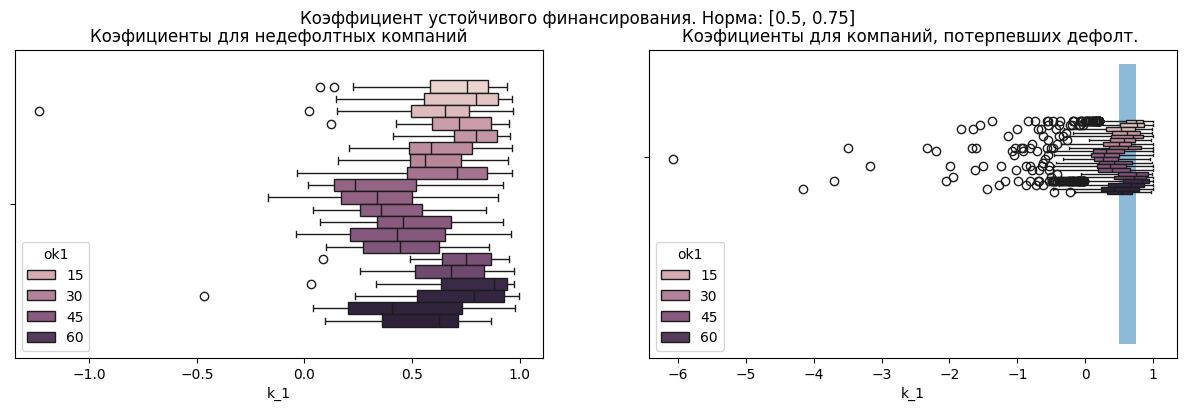

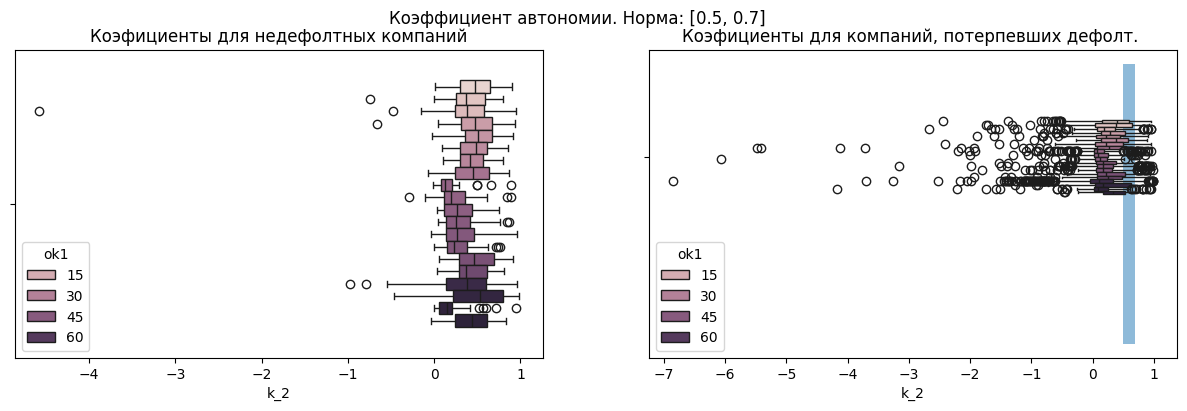

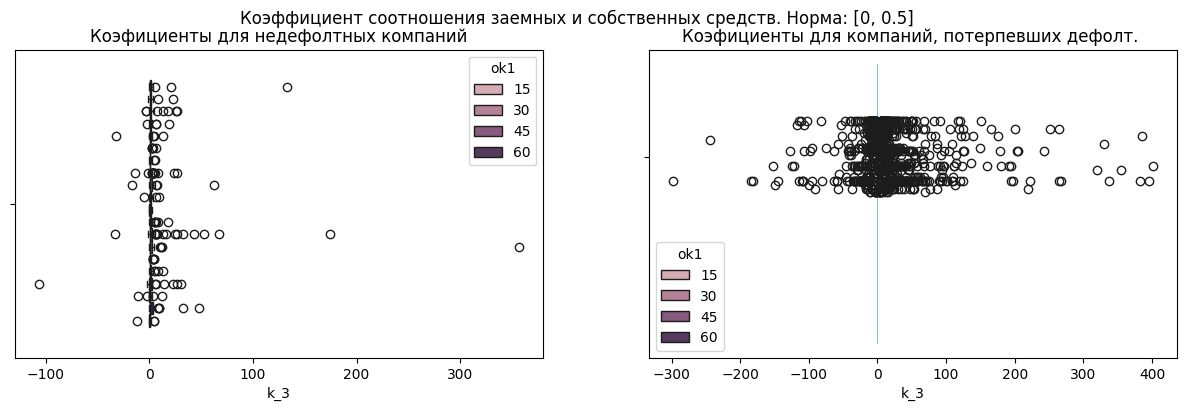

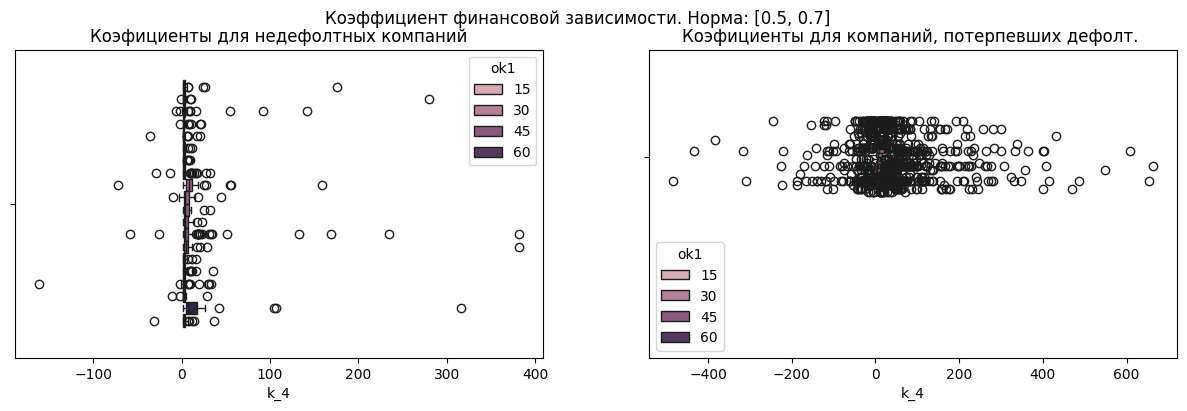

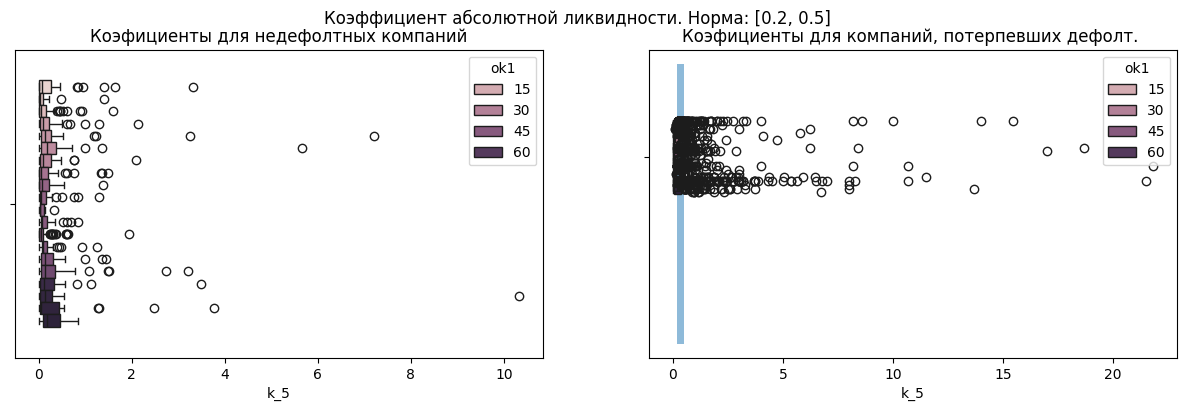

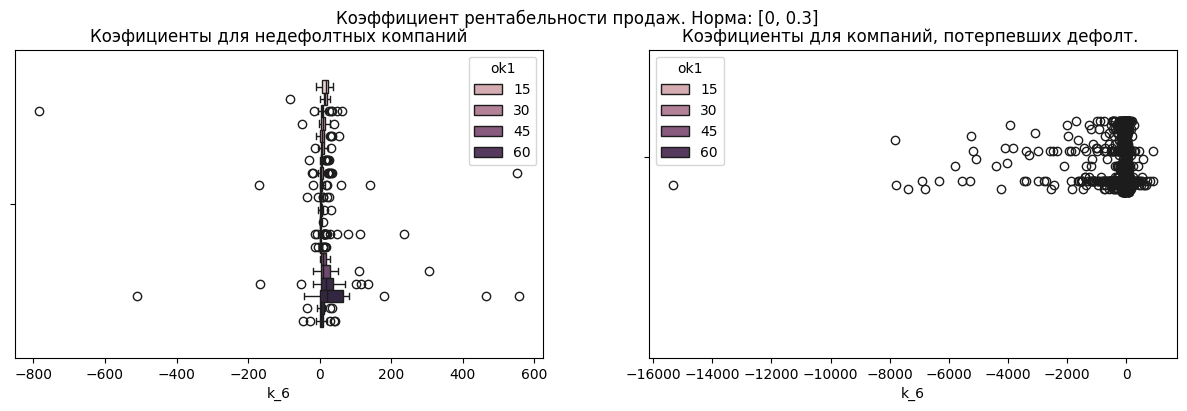

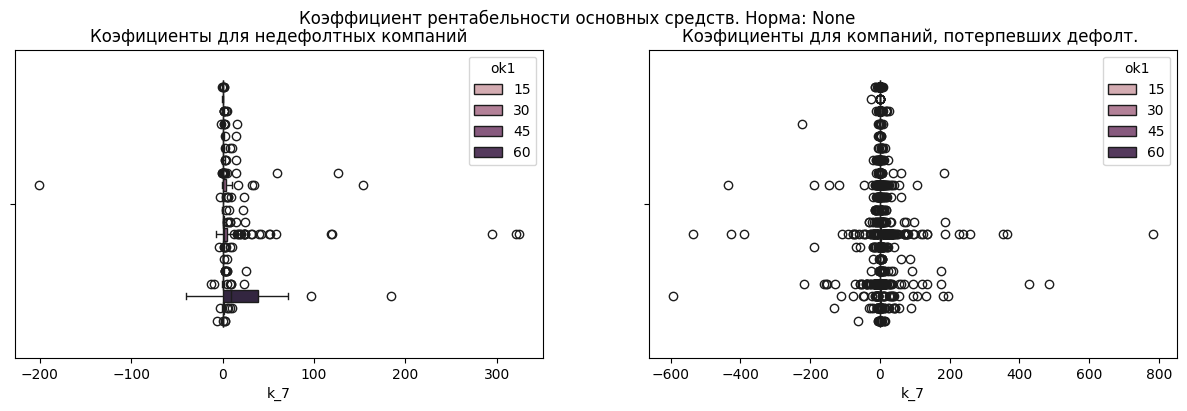

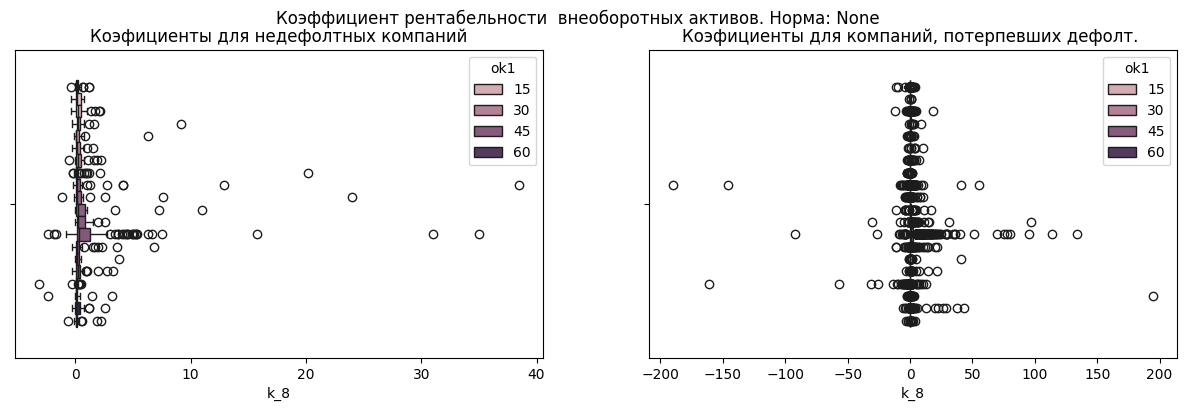

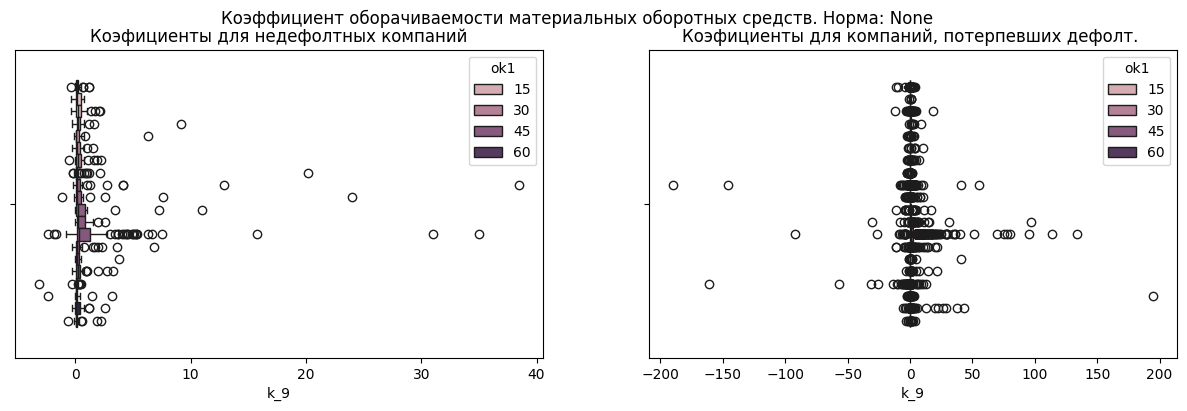

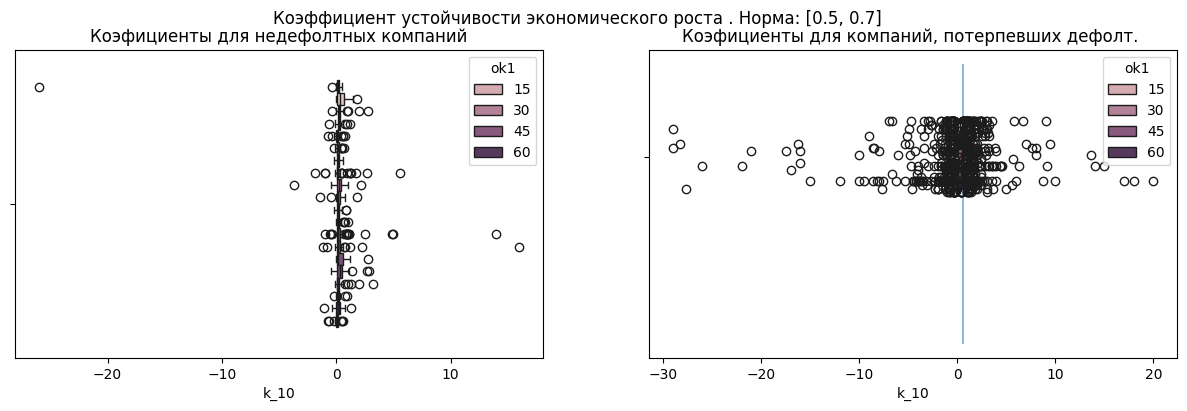

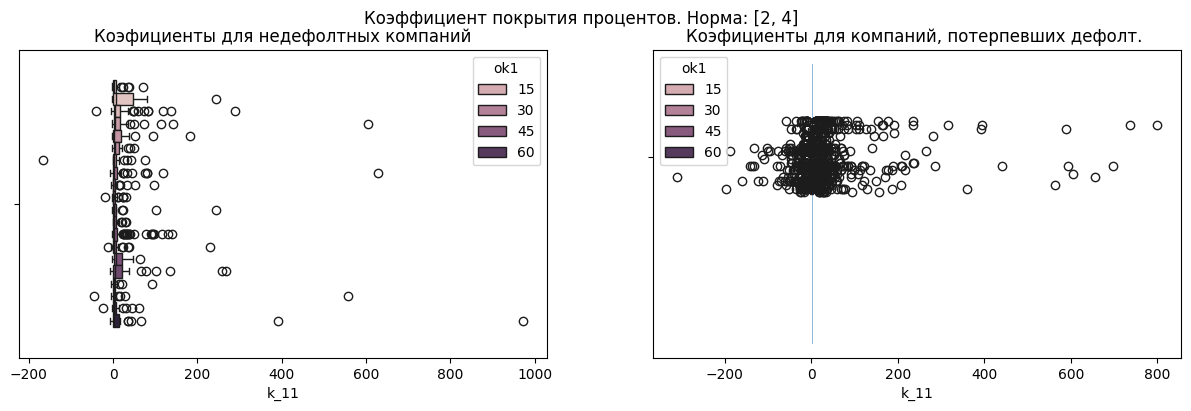

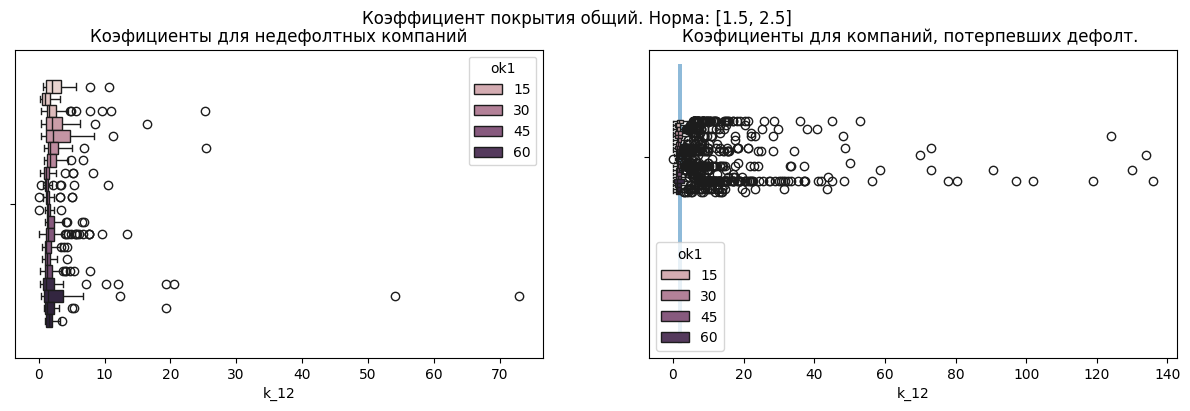

In [ ]:
for col in ['k_1', 'k_2', 'k_3', 'k_4', 'k_5', 'k_6', 'k_7', 'k_8', 'k_9', 'k_10', 'k_11', 'k_12']:
  plt.figure(figsize=(15,4))

  ax1 = plt.subplot(121)  #  (nrows, ncols, index)
  sns.boxplot(data=model_df[model_df['y']==0], x=col, hue='ok1', ax=ax1)
  ax1.set_title('Коэфициенты для недефолтных компаний')

  ax2 = plt.subplot(122)  #  (nrows, ncols, index)
  sns.boxplot(data=model_df[model_df['y']==1], x=col, hue='ok1', ax=ax2)
  ax2.set_title('Коэфициенты для компаний, потерпевших дефолт. ')

  try:
    plt.fill_between(x=koef_limits[col], y1=-1, y2=2, alpha=0.5)
  except:
    pass

  plt.suptitle(f'{koef_dict[col]}. Норма: {koef_limits[col]}')
  plt.show()

In [ ]:
print(f'Из-за чистки данных модель уменьшилась на {shape_1 - shape_2} строк. Итого наблюдений для оценки модели: {shape_2}')

Из-за чистки данных модель уменьшилась на 9349 строк. Итого наблюдений для оценки модели: 6627


# Оценка модели

В качестве модели будет использоваться модель бинарной классификации: логит-модель, а также альтернатива к ней - Метод Опорных Векторов или SVM. Зависимая переменная: дефолт/нет дефолта, с 12 объясняющими переменными – коэффициенты финансовой устойчивости, ликвидности и деловой активности, а также с дамми-переменными, отражающие принадлежность к отрасли. Уровень значимости возьму 5%.

In [ ]:
# Уровень значимости
a = 0.05

# Создам дамми переменную
model_df = pd.get_dummies(model_df, columns=['ok1'], drop_first=True)

# Выбор переменных
X = model_df.iloc[:, 41:]
y = model_df['y']


In [ ]:
# Проверка мультиколллинеарности
from patsy import dmatrices                                                       # для проверки мультиколлинеарности
from statsmodels.stats.outliers_influence import variance_inflation_factor        # для проверки мультиколлинеарности

formula = 'y' + '~' + '+'.join([col for col in X.columns])
y, X = dmatrices(formula, data=model_df, return_type='dataframe')
vif = pd.DataFrame()

vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif.drop(index=0, inplace=True)
vif[vif.VIF>5]

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF,variable
8,inf,k_8
9,inf,k_9


Две переменные сильно коррелированы друг с другом: Коэффициент рентабельности внеоборотных активов и Коэффициент оборачиваемости материальных оборотных средств. Удалю из модели коэффициент k_9.

In [ ]:
X.drop(columns=['k_9', 'Intercept'], inplace=True)

# Для тестирования модели разделю датасет на тестовый и тренировочный
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Логит

In [ ]:
# Оценка модели
log_reg = sm.Logit(y_train, X_train).fit()

df = pd.read_html(log_reg.summary().tables[1].as_html(), header=0)[0]
print(f"Незначимые коэффициенты: {len(df[df['P>|z|']>a].iloc[:,0].values)}.")

Optimization terminated successfully.
         Current function value: 0.399967
         Iterations 9
Незначимые коэффициенты: 9.


In [ ]:
# Оценка модели с исключением незначимых переменных
log_reg_1 = sm.Logit(y_train, X_train[df[df['P>|z|']<=a].iloc[:,0].values]).fit()


Optimization terminated successfully.
         Current function value: 0.401669
         Iterations 9


In [ ]:
# Логит без дамми-переменной
log_no_dum_reg = sm.Logit(y_train, X_train.iloc[:,1:12]).fit()

df_2 = pd.read_html(log_no_dum_reg.summary().tables[1].as_html(), header=0)[0]
print(f"Незначимые коэффициенты: {len(df_2[df_2['P>|z|']>a].iloc[:,0].values)}.")


Optimization terminated successfully.
         Current function value: 0.508321
         Iterations 8
Незначимые коэффициенты: 4.


In [ ]:
# Оценка модели с исключением незначимых переменных
log_no_dum_reg_1 = sm.Logit(y_train, X_train[df_2[df_2['P>|z|']<=a].iloc[:,0].values]).fit()


Optimization terminated successfully.
         Current function value: 0.509026
         Iterations 8


**LR тест**

Н0: разницы между оценёнными моделями нет.

Н1: полная модель лучше.


In [ ]:
pairs = [[log_no_dum_reg.llf, log_reg.llf], [log_no_dum_reg.llf, log_reg_1.llf],
         [log_no_dum_reg_1.llf, log_reg_1.llf], [log_reg_1.llf, log_reg.llf]]

for i in range(0,4):
  # Расчёт статистики
  LR_statistic = -2*(pairs[i][0] -pairs[i][1])

  # Расчёт p-value
  p_val = scipy.stats.chi2.sf(LR_statistic, 2)

  print(f'Тест {i+1}')
  print('Отвергаем Н0: полная модель лучше.') if p_val < 0.5 else print('Не отвергаем Н0: модели одинаковы.')
  print('\n')


Тест 1
Отвергаем Н0: полная модель лучше.


Тест 2
Отвергаем Н0: полная модель лучше.


Тест 3
Отвергаем Н0: полная модель лучше.


Тест 4
Отвергаем Н0: полная модель лучше.




Модель log_reg лучше.

In [ ]:
print('Вероятность иметь дефолт снижается, если увеличиваются:')
for i in df.iloc[:11,0][df['coef']<0]:
  print('   ',koef_dict[i])

print('\n')
print('Вероятность иметь дефолт снижается, если компания принадлежит к отрасли:')
for i in df.iloc[11:,0][df['coef']<0]:
  print('   ',okved_dict[i])


print('\n', '-'*120)
print('Вероятность иметь дефолт увеличивается, если увеличиваются:')
for i in df.iloc[:11,0][df['coef']>0]:
  print('   ',koef_dict[i])


print('\n')
print('Вероятность иметь дефолт увеличивается, если компания принадлежит к отрасли:')
for i in df.iloc[11:,0][df['coef']>0]:
  print('   ',okved_dict[i])
# okved_dict

Вероятность иметь дефолт снижается, если увеличиваются:
    Коэффициент автономии
    Коэффициент соотношения заемных и собственных средств
    Коэффициент абсолютной ликвидности
    Коэффициент рентабельности продаж
    Коэффициент рентабельности основных средств
    Коэффициент устойчивости экономического роста 
    Коэффициент покрытия процентов


Вероятность иметь дефолт снижается, если компания принадлежит к отрасли:

 ------------------------------------------------------------------------------------------------------------------------
Вероятность иметь дефолт увеличивается, если увеличиваются:
    Коэффициент устойчивого финансирования
    Коэффициент финансовой зависимости
    Коэффициент рентабельности  внеоборотных активов
    Коэффициент покрытия общий


Вероятность иметь дефолт увеличивается, если компания принадлежит к отрасли:
    Добыча сырой нефти и природного газа
    Производство пищевых продуктов
    Производство химических веществ и химических продуктов
    Произво

## SVM

In [ ]:
from sklearn.svm import SVC

# Оценка модели SVM
svm=SVC(C=1)
svm.fit(X_train,y_train)


## Сравнение моделей

#### Матрица ошибок

In [ ]:
from sklearn.metrics import confusion_matrix,  accuracy_score

predict_logit = list(map(round, log_reg.predict(X_test)))
predict_svm = svm.predict(X_test)

# Точность моделей на тестовом датасете
print(f'Точность, логит модель: {accuracy_score(y_test, predict_logit)}')
print(f'Точность, SVM         : {accuracy_score(y_test, predict_svm)}')

Точность, логит модель: 0.8495656149977138
Точность, SVM         : 0.8527663465935071


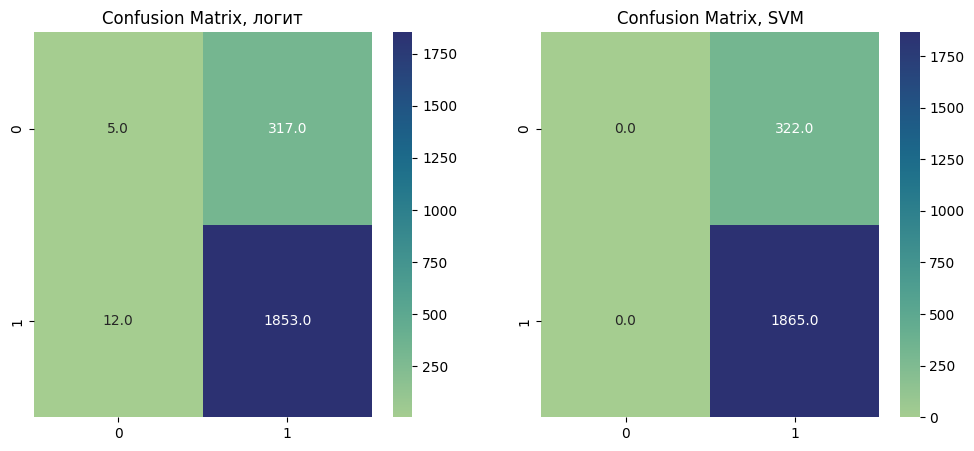

In [ ]:
# Матрица ошибок
cm1 = confusion_matrix(y_test, predict_logit)
cm2 = confusion_matrix(y_test, predict_svm)

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
sns.heatmap(pd.DataFrame(cm1), annot=True, fmt=".1f", cmap="crest", ax=ax1)
ax1.set_title("Confusion Matrix, логит")

ax2 = plt.subplot(122)
sns.heatmap(pd.DataFrame(cm2), annot=True, fmt=".1f", cmap="crest", ax=ax2)
ax2.set_title("Confusion Matrix, SVM")
plt.show()


Можно заметить, что обе модели часто совершают ошибки первого рода - модели прогнозируют не-дефолт для компании, хотя на самом деле компания обанкротилась (SVM - 322 случая, логит - 317 случаев). При этом SVM модель не делает ошибок второго рода (в отличии от логит-модели, которая ложно спрогнозировала 12 дефолтов, хотя на самом деле у компании всё хорошо с операционной деятельностью).

Логит модель лучше справилась с определением не-дефолтных случаев (5), в отличие от SVM-модели, которая не спрогнозировала ни одного. Хотя SVM-модель на 12 случаев больше спрогнозировала банкротств.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


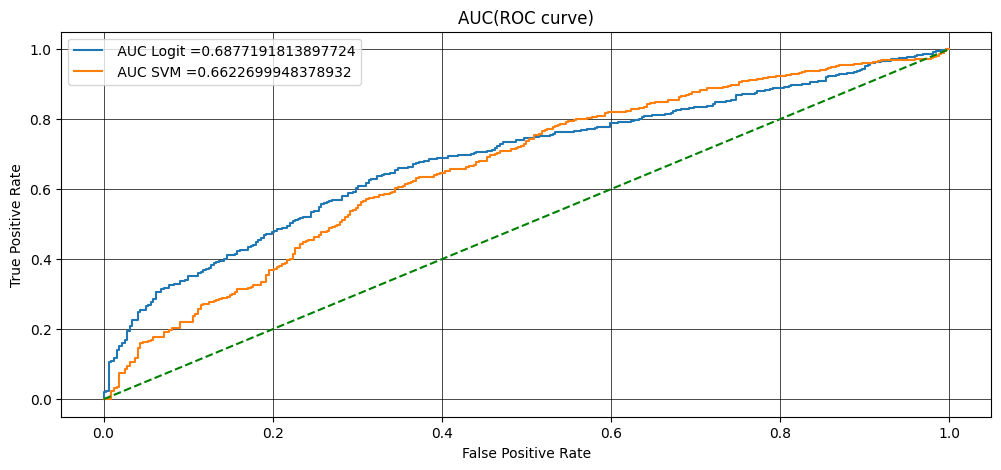

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
logit.fit(X_train,y_train)

logit_fpr, logit_tpr, logit_thresholds = roc_curve(y_test, logit.decision_function(X_test))
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, svm.decision_function(X_test))

plt.figure(figsize = (12,5))
plt.plot(logit_fpr, logit_tpr, label=" AUC Logit ="+str(auc(logit_fpr, logit_tpr)))
plt.plot(svm_fpr, svm_tpr, label=" AUC SVM ="+str(auc(svm_fpr, svm_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

Судя по auc, логит-модель показывает себя лучше.

# Выводы

Таким образом, svm-модель лучше прогнозирует дефолты, а логит-модель может прогнозировать не-дефолты. При этом логит-модель делает больше ошибок второго рода, и меньше ошибок первого рода.  

Точность (accuracy) выше у svm-модели. AUC больше у логит-модели.

---




В сравнении с оригинальной работой, данное исследование, помимо переноса на python, имеет следующие улучшения:
- в модель введена переменная, отражающая принадлежность отрасли;
- проведена проверка на адекватность полученных данных (исправление отрицательных строк баланса);
- поведена оценка на мультиколлинеарность объясняющих переменных;
- оценена альтернативная модель (метод опорных векторов, SVM);
- добавлены дополнительные метрики качества моделей (confusion matrix,  accuracy, auc).

Помимо всего прочего, построение моделей было сравнительно малотрудозатратным мероприятием. Сама подготовка данных заняла огромное количество времени.